# Step 4: Model Development

---

For classification problem, and with the constraint of choosing models from the assignment. There are 2 type of algorithm that are suitable to use:
- Losistic Regression Algorithm
- Tree-based Algorithm

Since our processed dataset contains roughly around 130,000 datapoints and 21 features, which is relatively large, we will test with these 4 models, and choose the best one:
- Logistic Regression (log_reg_1)
- Polynomial Logistic Regression with Degree 2 (log_reg_2)
- Decision Tree (decision_tree)
- Random Forest (random_forest)

| Model  | Strengths  | Weaknesses  | Suitability |
|---|---|---|---|
| Logistic Regression (log_reg_1)| Simple and efficient for binary classification, so can works with large datasets. | This draw linear relationship between features and target, so not capture all complex feature.  | Suitable for baseline model. |
| Polynomial Logistic Regression with Degree 2 (log_reg_2) | Can capture non-linear relationships with polynomial terms with complex features | Computational complexity and overfiiting grows rapidly with higher degrees with large dataset  | Capturing some non-linearities without lower degrees with lower complexity to explore potential non-linear relationships.                  |
| Decision Tree (decision_tree) | Captures complex non-linear relationships and feature interactions, while being intuitive and easy to interpret. It also can handles both numerical and categorical data without extensive preprocessing. | Easy to overfitting, especially trees with high depth. since they are sensitive to small variations in the data. | Suitable for capturing complex interactions between features and provides insights into feature importance.   |
| Random Forest (random_forest)  | Ensemble of decision trees so it reduces overfitting and improce performance while still maintains interpretability.  | Less interpretable than decision trees, and can be computationally expensive with large datasets.  | Improving predictive performance, and robustness against overfitting and noise. |

Due to the large dataset size, computational complexity of the polynomial logistic regression can grow exponentially fast, so we will stop at Degree 2 only.

For medical condition such as diabetes, both false positive and false negative could lead to severe effect on patient's health, time and money. A false positive (diagnosis), can make a normal person having to avoid certain types of food, causing inconvenience, or taking unnecessary medication like insulin injection, while a false negative, can prevent a patient from accesing the required medication, causing a deterioration in health condition. So we will need an indication that can balance between sensitivity (recall) and precision which is F1.

To evaluate the performance of those models, we will use 2 metrics:
- F1 score: Measure the performance of different models.
- AOC RUC: Measure the performance between different ML algorithm.

**Implementation:**
- We will use K-Fold cross validation with 5 split.
- We will use Grid Search and iterate through a list of hyperparameters for each models, to choose the best hyperparameter based on a rule.
- We then use those best hyperparameter to train our models and compare their performance metrics to choose out the best model.

## 1. Importing the necessary libraries

In [5]:
# Imports library for data manipulation and visualisation
import sys
sys.path.append("../utilities")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from color import color
import warnings
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



# ignore all warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

## 2. Data Preparation


In [6]:
df_train = pd.read_csv("../dataset/processed_train.csv")
df_test = pd.read_csv("../dataset/processed_test.csv")

In [7]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133275 entries, 0 to 133274
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                133275 non-null  int64  
 1   HighChol              133275 non-null  int64  
 2   BMI                   133275 non-null  float64
 3   Smoker                133275 non-null  int64  
 4   Stroke                133275 non-null  int64  
 5   HeartDiseaseorAttack  133275 non-null  int64  
 6   PhysActivity          133275 non-null  int64  
 7   Fruits                133275 non-null  int64  
 8   Veggies               133275 non-null  int64  
 9   HvyAlcoholConsump     133275 non-null  int64  
 10  NoDocbcCost           133275 non-null  int64  
 11  GenHlth               133275 non-null  float64
 12  MentHlth              133275 non-null  int64  
 13  PhysHlth              133275 non-null  int64  
 14  DiffWalk              133275 non-null  int64  
 15  

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income,ExtraMedTest,ExtraAlcoholTest,Status
count,133275.000000,133275.000000,1.332750e+05,133275.000000,133275.000000,133275.000000,133275.000000,133275.000000,133275.000000,133275.000000,...,1.332750e+05,133275.000000,133275.000000,133275.000000,133275.000000,1.332750e+05,1.332750e+05,1.332750e+05,1.332750e+05,133275.000000
mean,0.492613,0.473877,4.179820e-17,0.459403,0.050775,0.119925,0.730722,0.625181,0.800360,0.050467,...,5.800566e-17,0.205080,0.267522,0.209574,0.447676,3.565642e-16,1.505588e-16,8.530245e-18,-2.388469e-17,0.400120
std,0.499947,0.499319,1.000004e+00,0.498351,0.219538,0.324875,0.443586,0.484078,0.399731,0.218908,...,1.000004e+00,0.403761,0.442669,0.407006,0.497257,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489924
min,0.000000,0.000000,-2.485713e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.512831e+00,0.000000,0.000000,0.000000,0.000000,-2.456936e+00,-2.287149e+00,-2.600881e+00,-2.607127e+00,0.000000
25%,0.000000,0.000000,-7.367234e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-6.071059e-01,0.000000,0.000000,0.000000,0.000000,-7.765912e-01,-8.803793e-01,-6.186323e-01,-6.203128e-01,0.000000
50%,0.000000,0.000000,-1.537269e-01,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,2.986191e-01,0.000000,0.000000,0.000000,0.000000,2.316159e-01,5.746706e-02,-1.808350e-01,-1.815073e-01,0.000000
75%,1.000000,1.000000,4.292696e-01,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,2.986191e-01,0.000000,1.000000,0.000000,1.000000,5.676849e-01,9.953134e-01,8.285311e-01,8.301832e-01,1.000000
max,1.000000,1.000000,1.004871e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.110069e+00,1.000000,1.000000,1.000000,1.000000,1.575892e+00,9.953134e-01,2.239211e+00,2.244112e+00,1.000000


In [8]:
df_train.head

<bound method NDFrame.head of         HighBP  HighChol       BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0            0         0 -1.028222       0       0                     0   
1            1         1 -0.445225       0       0                     0   
2            0         1  7.279479       0       0                     0   
3            0         1 -0.445225       0       0                     0   
4            1         0  0.866517       1       0                     0   
...        ...       ...       ...     ...     ...                   ...   
133270       1         0 -0.590974       1       0                     0   
133271       1         1 -1.319720       0       0                     1   
133272       1         1 -0.299476       1       0                     0   
133273       0         0  0.429270       1       0                     1   
133274       1         1 -1.028222       1       0                     1   

        PhysActivity  Fruits  Veggies  HvyAlcoholConsump 

In [9]:
df_test.info()
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50686 entries, 0 to 50685
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                50686 non-null  int64  
 1   HighChol              50686 non-null  int64  
 2   BMI                   50686 non-null  float64
 3   Smoker                50686 non-null  int64  
 4   Stroke                50686 non-null  int64  
 5   HeartDiseaseorAttack  50686 non-null  int64  
 6   PhysActivity          50686 non-null  int64  
 7   Fruits                50686 non-null  int64  
 8   Veggies               50686 non-null  int64  
 9   HvyAlcoholConsump     50686 non-null  int64  
 10  NoDocbcCost           50686 non-null  int64  
 11  GenHlth               50686 non-null  float64
 12  MentHlth              50686 non-null  int64  
 13  PhysHlth              50686 non-null  int64  
 14  DiffWalk              50686 non-null  int64  
 15  Sex                

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income,ExtraMedTest,ExtraAlcoholTest,Status
count,50686.000000,50686.000000,5.068600e+04,50686.000000,50686.000000,50686.000000,50686.000000,50686.000000,50686.000000,50686.000000,...,5.068600e+04,50686.000000,50686.000000,50686.000000,50686.000000,5.068600e+04,5.068600e+04,5.068600e+04,5.068600e+04,0.0
mean,0.430494,0.423470,-4.612724e-15,0.445646,0.039518,0.093438,0.757270,0.629503,0.810875,0.057393,...,-3.420519e-16,0.189875,0.231701,0.166456,0.443673,2.371934e-16,-1.405006e-16,-1.780352e-17,3.336408e-17,NaN
std,0.495150,0.494113,1.000010e+00,0.497042,0.194825,0.291048,0.428737,0.482943,0.391612,0.232593,...,1.000010e+00,0.392206,0.421923,0.372493,0.496822,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,NaN
min,0.000000,0.000000,-5.910515e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.604766e+00,0.000000,0.000000,0.000000,0.000000,-2.114380e+00,-1.926688e+00,-2.528539e+00,-2.515536e+00,NaN
25%,0.000000,0.000000,-6.720110e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,-3.743119e-01,0.000000,0.000000,0.000000,0.000000,-6.940724e-01,-6.951760e-01,-6.323014e-01,-6.378422e-01,NaN
50%,0.000000,0.000000,-4.817951e-02,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,-3.743119e-01,0.000000,0.000000,0.000000,0.000000,-4.237341e-02,3.946181e-01,1.477111e-01,1.534715e-01,NaN
75%,1.000000,1.000000,6.088137e-01,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,5.537677e-01,0.000000,0.000000,0.000000,1.000000,6.392034e-01,1.047405e+00,5.915113e-01,5.826586e-01,NaN
max,1.000000,1.000000,3.858817e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.003797e+00,1.000000,1.000000,1.000000,1.000000,1.706932e+00,1.047405e+00,2.823961e+00,2.822479e+00,NaN


Data splitting

In [10]:
x = df_train.drop(["Status"], axis=1)
y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80 - 20
)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")

x_train: (106620, 20)
y_train: (106620, 1)
x_val: (26655, 20)
y_val: (26655, 1)


Creating K-Fold cross validation with 5 splits for choosing the best hyperparameter.

In [11]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=0)

## 3. Logistic Regression 


### 3.1 Setting Hyperparameters

For the hyperparameters of the logistic regrssion algorithm:
- Degree of freedom C = 1/$\lambda$
- Regularization type: L1 (Lasso) and L2 (Ridge)

In [12]:
hyper_para = {
    "C": 1 / np.logspace(-2, 2, num=25),
    "penalty": ["l1", "l2"]
}

In [13]:
log_reg = LogisticRegression(random_state=0, solver='saga', max_iter=1000, class_weight='balanced')

In [14]:
clfs_perf = dict()
clfs_hyperpara = dict()

We will use grid search to train our classifier for each of those lambda values and evaluate their performance

### 3.2 Logistic Regression (1st Degree)

In [15]:
grid_clf = GridSearchCV(log_reg, hyper_para, cv=cross_val, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs=-1) # n_jobs = 1 use all CPU, becareful to freeze your computer
grid_clf.fit(x_train, y_train.values.ravel())

y_train_pred = grid_clf.predict(x_train)
y_val_pred = grid_clf.predict(x_val)
clfs_perf["log_reg_1"] = grid_clf

By default, GridSearchCV will choose the hyperparameter with the highest score, however, in many case this can lead to a overfitting situation where the performance between the train and validation dataset is vastly different. This will make our model perform well on train dataset, but might fail to generalize with the new unseen data.

To avoid this problem, we will choose a hyperparameter where the **gap (difference in performance) between the train and validation dataset is the smallest**, so that our model will have the ability to generalize.

Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.8501752723748016
Params with least gap between train and validation scores: {'C': 0.01, 'penalty': 'l1'}
Train score with least gap: 0.8497970635502039
Validation score with least gap: 0.8497652708222286


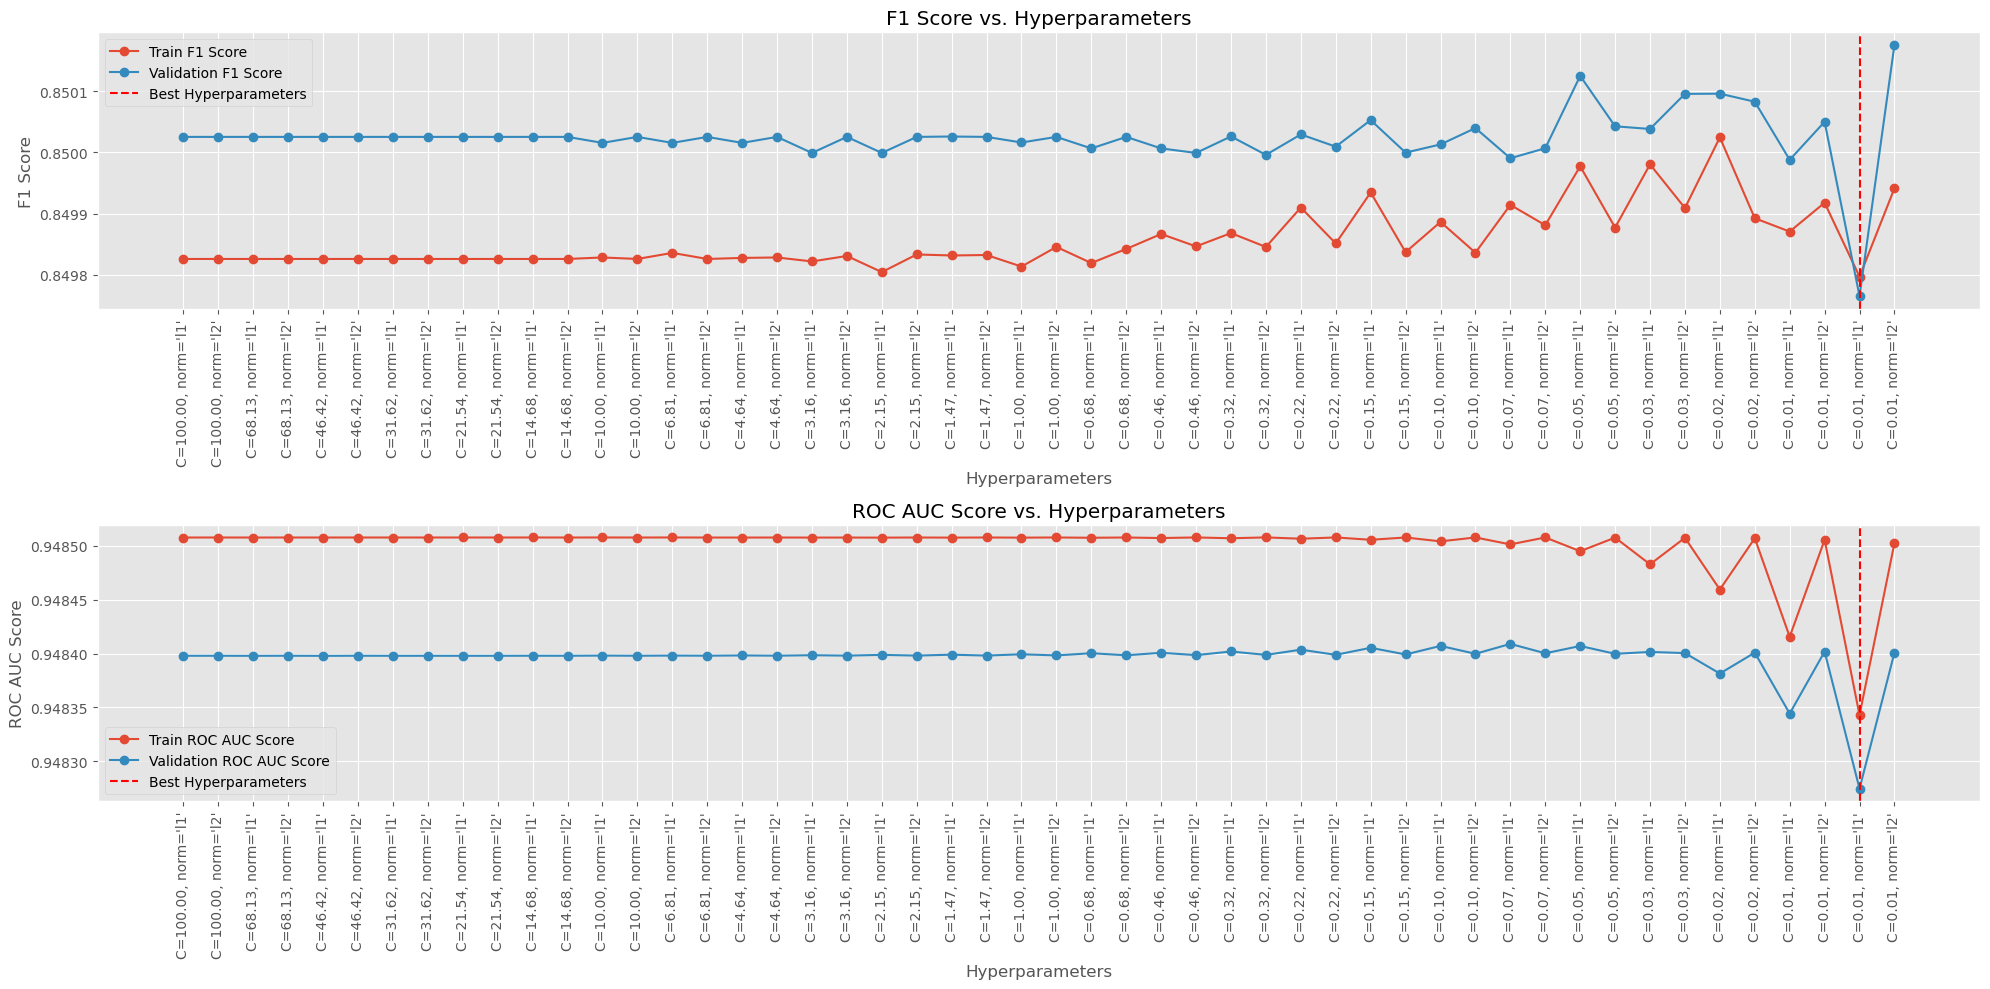

In [16]:
def visualize_cls(grid_clf):  
    # Extracting the results from grid search
    train_f1_scores = grid_clf.cv_results_['mean_train_f1']
    val_f1_scores = grid_clf.cv_results_['mean_test_f1']
    train_roc_auc_scores = grid_clf.cv_results_['mean_train_roc_auc']
    val_roc_auc_scores = grid_clf.cv_results_['mean_test_roc_auc']
    hyper_params = grid_clf.cv_results_['params']

    # Extracting and formatting hyperparameter labels
    hyper_param_labels = [f"C={param['C']:.2f}, norm='{param['penalty']}'" for param in hyper_params]

    # Calculate the absolute difference between train and validation scores
    score_diff = np.abs(train_f1_scores - val_f1_scores)

    # Find the index where the difference is minimized
    least_gap_index = np.argmin(score_diff)

    least_gap_params = grid_clf.cv_results_['params'][least_gap_index]

    print("Best parameters:", grid_clf.best_params_)
    print("Best score:", grid_clf.best_score_)
    print("Params with least gap between train and validation scores:", least_gap_params)
    print("Train score with least gap:", grid_clf.cv_results_['mean_train_f1'][least_gap_index])
    print("Validation score with least gap:", grid_clf.cv_results_['mean_test_f1'][least_gap_index])
    
    clfs_hyperpara["log_reg_1"] = least_gap_params

    # Plotting F1 scores
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(hyper_params)), train_f1_scores, label='Train F1 Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=least_gap_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    # Plotting ROC AUC scores
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(hyper_params)), train_roc_auc_scores, label='Train ROC AUC Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_roc_auc_scores, label='Validation ROC AUC Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=least_gap_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
visualize_cls(grid_clf)

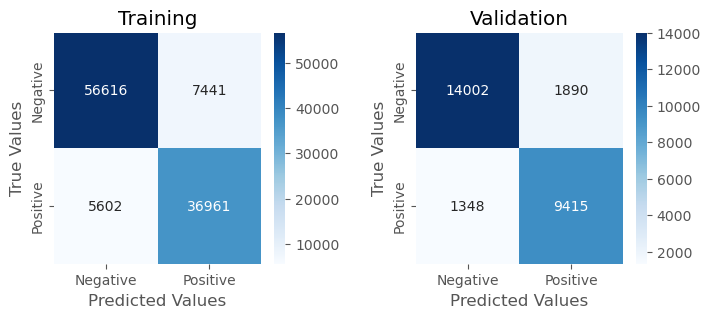

Training Dataset
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     64057
           1       0.83      0.87      0.85     42563

    accuracy                           0.88    106620
   macro avg       0.87      0.88      0.87    106620
weighted avg       0.88      0.88      0.88    106620

Validation Dataset
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     15892
           1       0.83      0.87      0.85     10763

    accuracy                           0.88     26655
   macro avg       0.87      0.88      0.87     26655
weighted avg       0.88      0.88      0.88     26655



In [17]:
def show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y):
    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

    sns.heatmap(confusion_matrix(train_y, train_pred_y), annot=True, cmap="Blues", fmt="g", ax=axis[0])
    axis[0].set_xlabel("Predicted Values")
    axis[0].set_ylabel("True Values")
    axis[0].set_title("Training")

    axis[0].set_xticks([0.5, 1.5])
    axis[0].set_xticklabels(["Negative", "Positive"])
    axis[0].set_yticks([0.5, 1.5])
    axis[0].set_yticklabels(["Negative", "Positive"])

    sns.heatmap(confusion_matrix(val_y, val_pred_y), annot=True, cmap="Blues", fmt="g", ax=axis[1])
    axis[1].set_xlabel("Predicted Values")
    axis[1].set_ylabel("True Values")
    axis[1].set_title("Validation")

    axis[1].set_xticks([0.5, 1.5])
    axis[1].set_xticklabels(["Negative", "Positive"])
    axis[1].set_yticks([0.5, 1.5])
    axis[1].set_yticklabels(["Negative", "Positive"])

    fig.subplots_adjust(wspace=0.4)

    plt.show()

    print(color.RED + color.BOLD + "Training Dataset" + color.END)
    print(f"{classification_report(train_y, train_pred_y)}")
    print(color.BLUE + color.BOLD + "Validation Dataset" + color.END)
    print(f"{classification_report(val_y, val_pred_y)}")
    
show_train_val_confusion_matrix(y_train, y_train_pred, y_val, y_val_pred)

There is a very high difference in performance between the train and validation dataset until a very low C. This indicate a very strong penalties toward a simpler solution. In theory, this should reduce overfitting

### 3.3 Polynomial Logistic Regression (2nd Degree)

In [18]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
x_train_poly_2 = poly.fit_transform(x_train)
x_val_poly_2 = poly.transform(x_val)

In [19]:
grid_clf = GridSearchCV(log_reg, hyper_para, cv=cross_val, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs=-1)
grid_clf.fit(x_train_poly_2, y_train.values.ravel())

y_train_pred = grid_clf.predict(x_train_poly_2)
y_val_pred = grid_clf.predict(x_val_poly_2)
clfs_perf["log_reg_2"] = grid_clf

As you can see, a polynomial logistic regression with degree of 2 already took about 83 minutes to finished fitting, given n_jobs=-1 and CPU train is AMD Ryzen 5 3600 - 6 cores at 4.04 GHz. So will not move further than degree 2, since with gridsearch of 25 it would take thousands of minutes to finished.

Since we are still using the same logistic regression algorithm, we will also take the hyperparameter with the smallest gap.

Best parameters: {'C': 0.021544346900318846, 'penalty': 'l2'}
Best score: 0.8668682525500472
Params with least gap between train and validation scores: {'C': 0.014677992676220705, 'penalty': 'l1'}
Train score with least gap: 0.865819817449602
Validation score with least gap: 0.8654414148628332


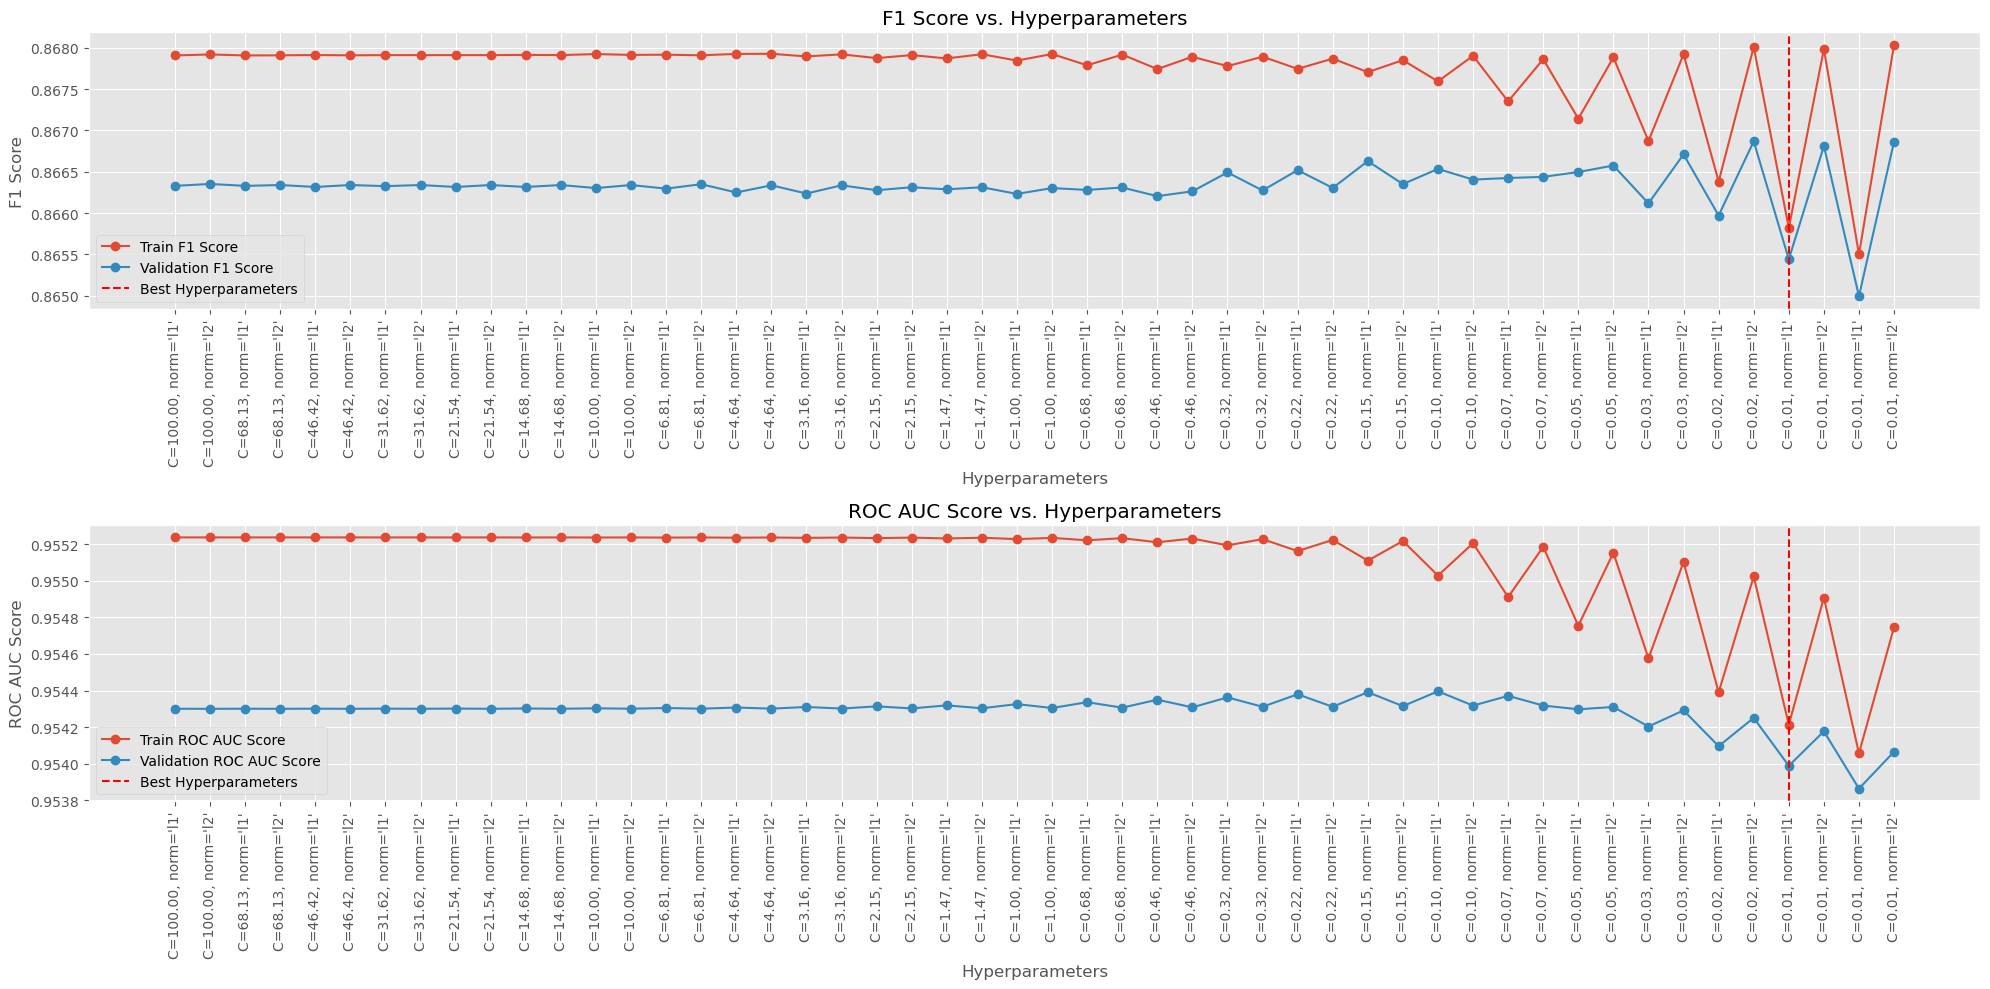

In [20]:
def visualize_cls(grid_clf):  
    # Extracting the results from grid search
    train_f1_scores = grid_clf.cv_results_['mean_train_f1']
    val_f1_scores = grid_clf.cv_results_['mean_test_f1']
    train_roc_auc_scores = grid_clf.cv_results_['mean_train_roc_auc']
    val_roc_auc_scores = grid_clf.cv_results_['mean_test_roc_auc']
    hyper_params = grid_clf.cv_results_['params']

    # Extracting and formatting hyperparameter labels
    hyper_param_labels = [f"C={param['C']:.2f}, norm='{param['penalty']}'" for param in hyper_params]

    # Calculate the absolute difference between train and validation scores
    score_diff = np.abs(train_f1_scores - val_f1_scores)

    # Find the index where the difference is minimized
    least_gap_index = np.argmin(score_diff)

    least_gap_params = grid_clf.cv_results_['params'][least_gap_index]

    print("Best parameters:", grid_clf.best_params_)
    print("Best score:", grid_clf.best_score_)
    print("Params with least gap between train and validation scores:", least_gap_params)
    print("Train score with least gap:", grid_clf.cv_results_['mean_train_f1'][least_gap_index])
    print("Validation score with least gap:", grid_clf.cv_results_['mean_test_f1'][least_gap_index])
    
    clfs_hyperpara["log_reg_2"] = least_gap_params

    # Plotting F1 scores
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(hyper_params)), train_f1_scores, label='Train F1 Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=least_gap_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    # Plotting ROC AUC scores
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(hyper_params)), train_roc_auc_scores, label='Train ROC AUC Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_roc_auc_scores, label='Validation ROC AUC Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=least_gap_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_cls(grid_clf)

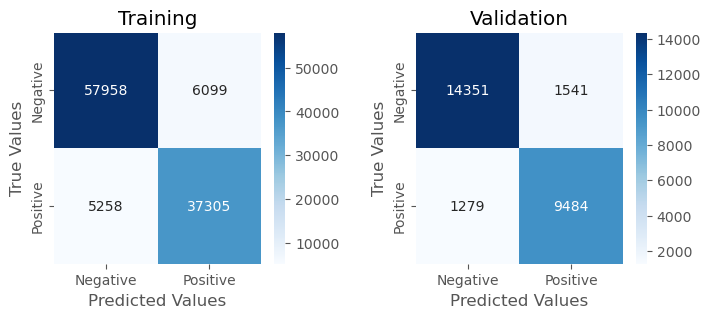

Training Dataset
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     64057
           1       0.86      0.88      0.87     42563

    accuracy                           0.89    106620
   macro avg       0.89      0.89      0.89    106620
weighted avg       0.89      0.89      0.89    106620

Validation Dataset
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     15892
           1       0.86      0.88      0.87     10763

    accuracy                           0.89     26655
   macro avg       0.89      0.89      0.89     26655
weighted avg       0.89      0.89      0.89     26655



In [21]:
show_train_val_confusion_matrix(y_train, y_train_pred, y_val, y_val_pred)

Once again, there is a very high difference in performance between the train and validation dataset until a very low C. This indicate a very strong penalties toward a simpler solution. In theory, this should reduce overfitting

## 4. Decision Tree

### 4.1 Setting Hyperparameters

In [22]:
hyper_para = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
    "criterion": ['gini', 'entropy']
}

### 4.2 Decision Tree Model

In [23]:
decision_tree_clf = DecisionTreeClassifier(
    random_state=0            # Reproducible result
)

grid_clf = GridSearchCV(decision_tree_clf, hyper_para, cv=cross_val, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs=-1)
grid_clf.fit(x_train, y_train.values.ravel())

y_train_pred = grid_clf.predict(x_train)
y_val_pred = grid_clf.predict(x_val)
clfs_perf["decision_tree"] = grid_clf

For tree-based algorithm, we obviously should not take the hyperparameter with highest score as they are just overfitting. There are also many points where the gap is 0 but the performance is low, so in this case, we will choose the hyperparameter based on a **combined score, that balance between the gap and the performance**

Params with highest score: {'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 2}
Params with best combine score between train and validation scores: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Train score with best parameters: 0.9107636830494584
Validation score with best parameters: 0.9062242744559506


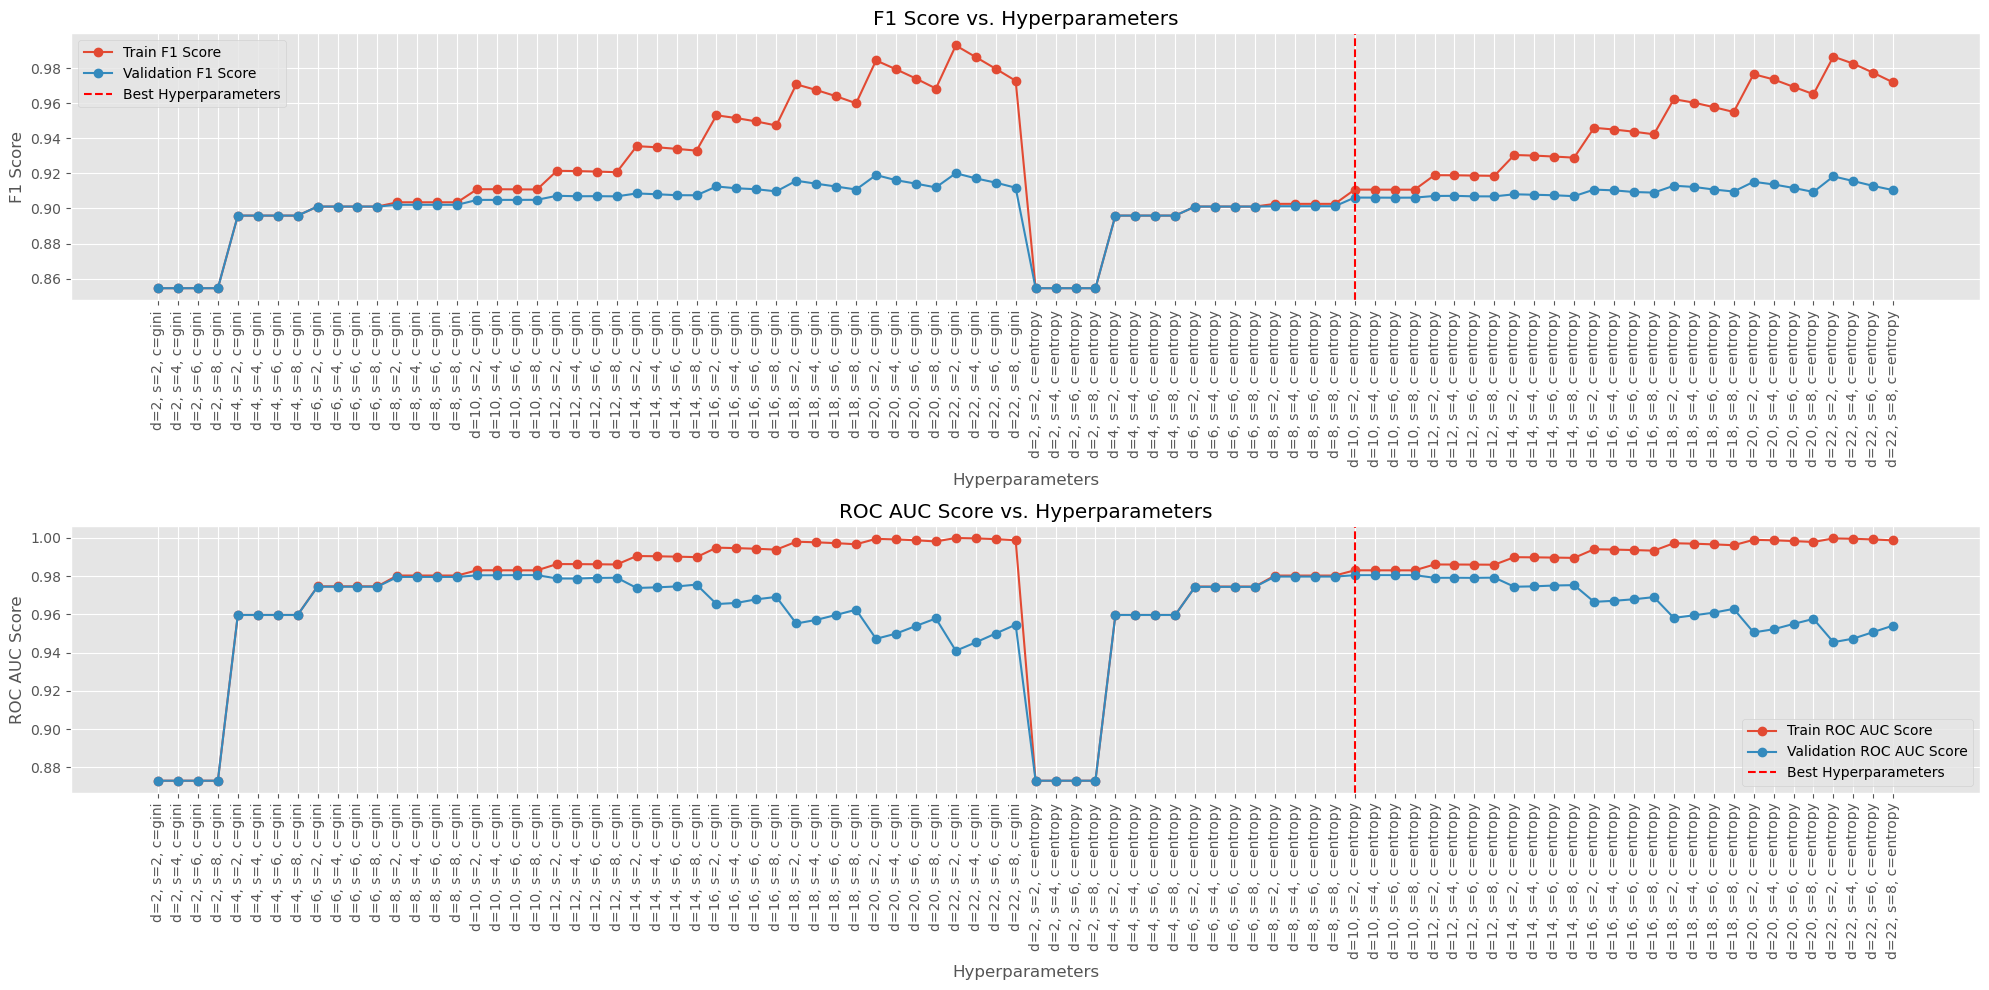

In [24]:
def visualize_cls(grid_clf):
    # Extracting the results from grid search
    train_f1_scores = grid_clf.cv_results_['mean_train_f1']
    val_f1_scores = grid_clf.cv_results_['mean_test_f1']
    train_roc_auc_scores = grid_clf.cv_results_['mean_train_roc_auc']
    val_roc_auc_scores = grid_clf.cv_results_['mean_test_roc_auc']
    hyper_params = grid_clf.cv_results_['params']

    # Calculate the absolute difference between train and validation scores
    score_diff = np.abs(train_f1_scores - val_f1_scores)

    # Define a scoring function that combines gap and score
    combined_scores = val_f1_scores - 0.5 * score_diff

    # Find the index where the combined score is maximized
    best_index = np.argmax(combined_scores)
    best_params = hyper_params[best_index]
    
    hyper_param_labels = [f"d={param['max_depth']}, s={param['min_samples_split']}, c={param['criterion']}" for param in hyper_params]


    print("Params with highest score:", grid_clf.best_params_)
    # print("Best combined score:", combined_scores[best_index])
    print("Params with best combine score between train and validation scores:", best_params)
    print("Train score with best parameters:", train_f1_scores[best_index])
    print("Validation score with best parameters:", val_f1_scores[best_index])
    
    clfs_hyperpara["decision_tree"] = best_params

    # Plotting F1 scores
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(hyper_params)), train_f1_scores, label='Train F1 Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    # Plotting ROC AUC scores
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(hyper_params)), train_roc_auc_scores, label='Train ROC AUC Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_roc_auc_scores, label='Validation ROC AUC Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
visualize_cls(grid_clf)

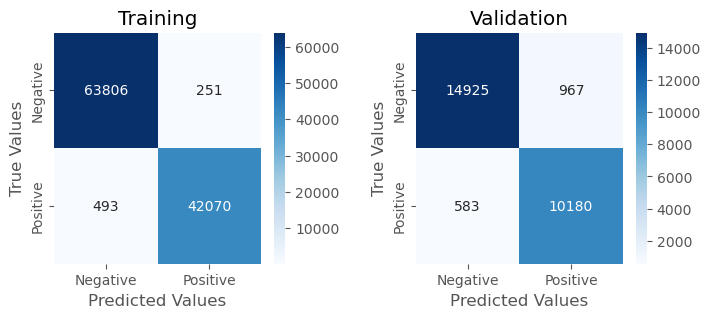

Training Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     64057
           1       0.99      0.99      0.99     42563

    accuracy                           0.99    106620
   macro avg       0.99      0.99      0.99    106620
weighted avg       0.99      0.99      0.99    106620

Validation Dataset
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     15892
           1       0.91      0.95      0.93     10763

    accuracy                           0.94     26655
   macro avg       0.94      0.94      0.94     26655
weighted avg       0.94      0.94      0.94     26655



In [25]:
show_train_val_confusion_matrix(y_train, y_train_pred, y_val, y_val_pred)

## 5. Random Forest

### 5.1 Setting Hyperparameters

In [26]:
hyper_para = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
    "criterion": ['gini', 'entropy'],
    "max_features": ['auto', 'sqrt', 'log2'],
}

### 5.2 Random Forest Model

In [27]:
random_forest_clf = RandomForestClassifier(
    random_state=0     # Reproducible result
)

grid_clf = GridSearchCV(random_forest_clf, hyper_para, cv=cross_val, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True, n_jobs=-1)
grid_clf.fit(x_train, y_train.values.ravel())

y_train_pred = grid_clf.predict(x_train)
y_val_pred = grid_clf.predict(x_val)
clfs_perf["random_forest"] = grid_clf

Same as above, we will also choose the hyperparameter based on a **combined score, that balance between the gap and the performance**, but added a threshold for the gap and the score this time.

Params with highest score: {'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'n_estimators': 20}
Params with best score and smallest gap: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}
Train score with best parameters: 0.9115044531987131
Validation score with best parameters: 0.9063374752542652


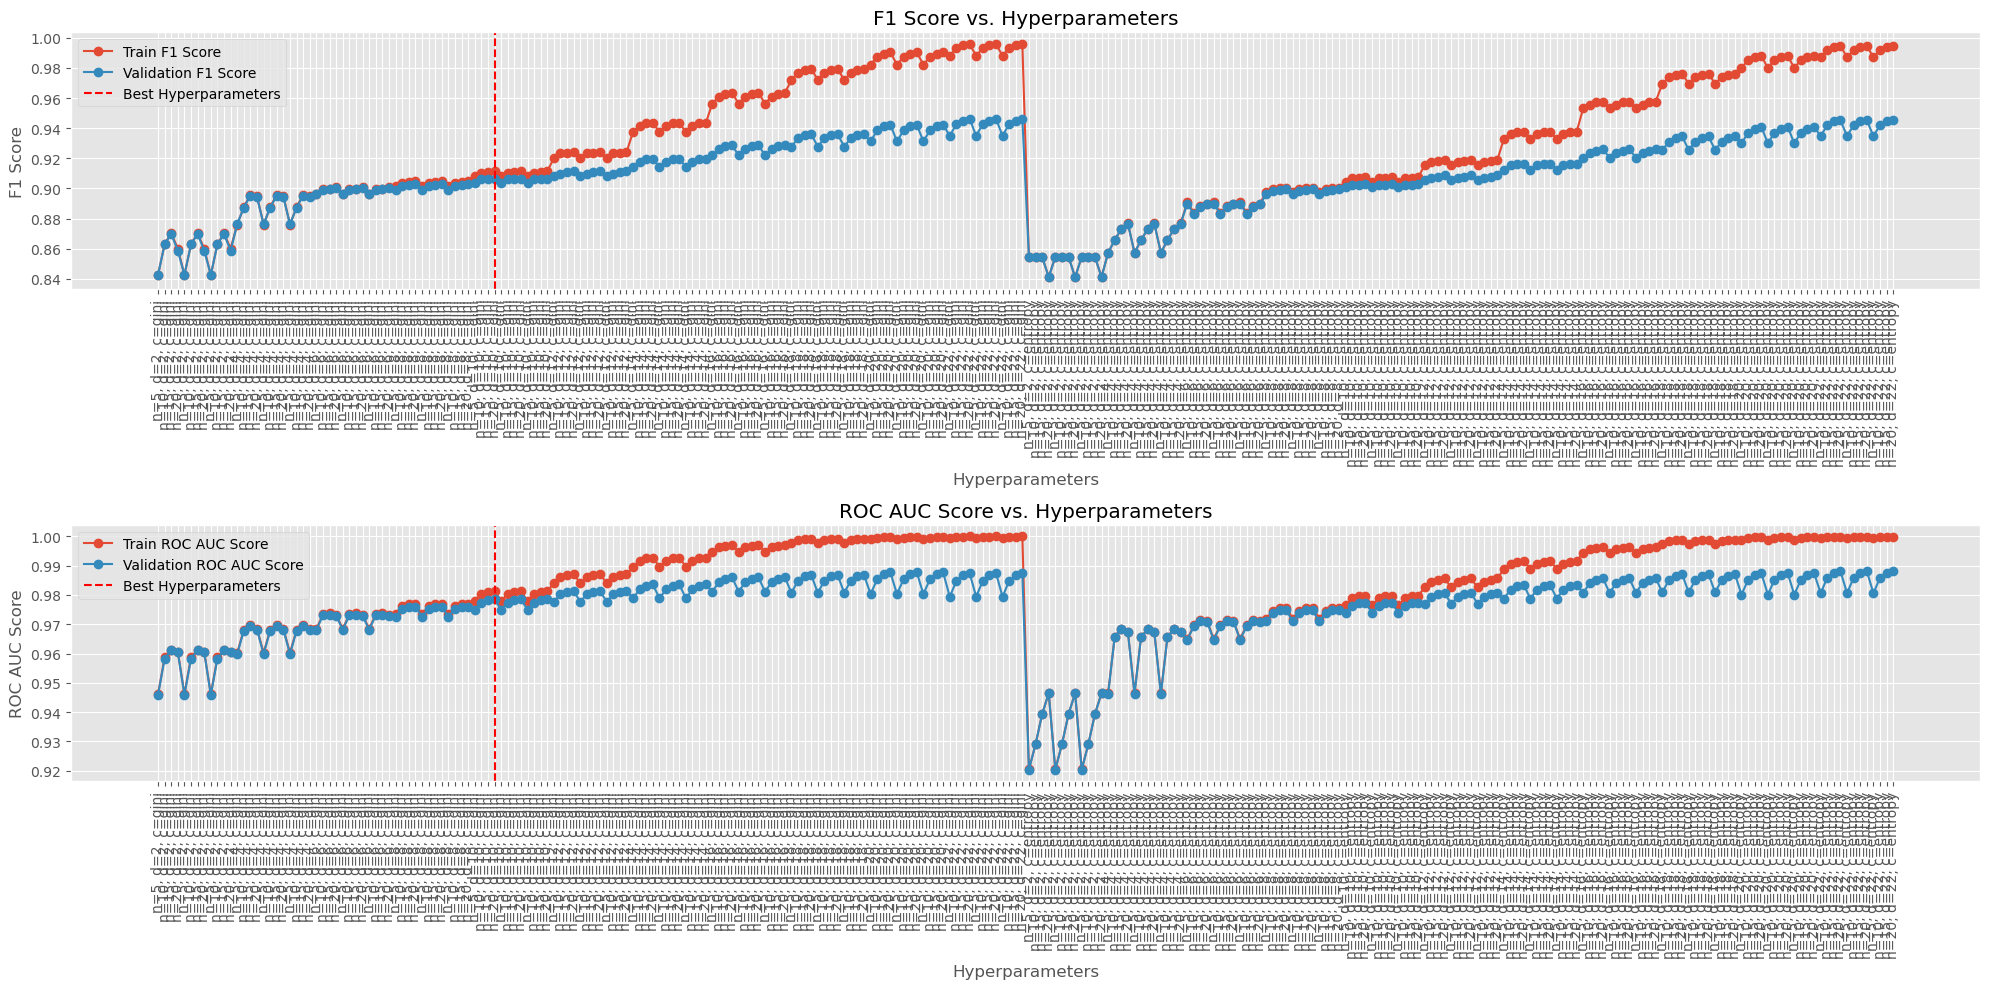

In [28]:
def visualize_cls(grid_clf):
    # Extracting the results from grid search
    train_f1_scores = grid_clf.cv_results_['mean_train_f1']
    val_f1_scores = grid_clf.cv_results_['mean_test_f1']
    train_roc_auc_scores = grid_clf.cv_results_['mean_train_roc_auc']
    val_roc_auc_scores = grid_clf.cv_results_['mean_test_roc_auc']
    hyper_params = grid_clf.cv_results_['params']

    # Calculate the absolute difference between train and validation scores
    score_diff = np.abs(train_f1_scores - val_f1_scores)

    # Define thresholds for score and gap
    score_threshold = 0.8  
    gap_threshold = 0.01 

    # Find the index where the validation score is above the threshold and gap is below the threshold
    candidate_indices = np.where((val_f1_scores > score_threshold) & (score_diff < gap_threshold))[0]

    # Choose the hyperparameters with the highest validation F1 score among the candidates
    best_index = candidate_indices[np.argmax(val_f1_scores[candidate_indices])]
    best_params = hyper_params[best_index]

    hyper_param_labels = [f"n={param['n_estimators']}, d={param['max_depth']}, c={param['criterion']}" for param in hyper_params]

    print("Params with highest score:", grid_clf.best_params_)
    print("Params with best score and smallest gap:", best_params)
    print("Train score with best parameters:", train_f1_scores[best_index])
    print("Validation score with best parameters:", val_f1_scores[best_index])
    
    clfs_hyperpara["random_forest"] = best_params

    # Plotting F1 scores
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(hyper_params)), train_f1_scores, label='Train F1 Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_f1_scores, label='Validation F1 Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    # Plotting ROC AUC scores
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(hyper_params)), train_roc_auc_scores, label='Train ROC AUC Score', marker='o')
    plt.plot(np.arange(len(hyper_params)), val_roc_auc_scores, label='Validation ROC AUC Score', marker='o')
    plt.xlabel('Hyperparameters')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs. Hyperparameters')
    plt.xticks(np.arange(len(hyper_params)), hyper_param_labels, rotation=90)
    plt.axvline(x=best_index, color='r', linestyle='--', label='Best Hyperparameters')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_cls(grid_clf)

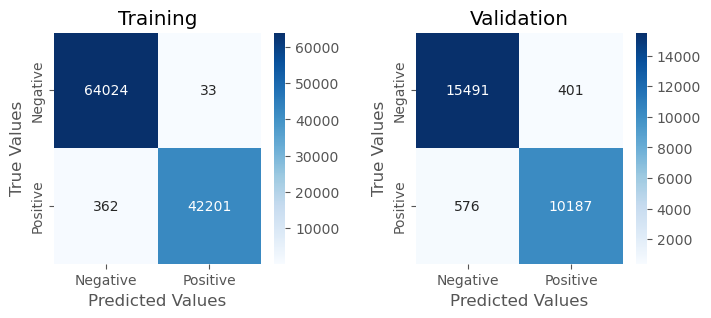

Training Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     64057
           1       1.00      0.99      1.00     42563

    accuracy                           1.00    106620
   macro avg       1.00      1.00      1.00    106620
weighted avg       1.00      1.00      1.00    106620

Validation Dataset
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     15892
           1       0.96      0.95      0.95     10763

    accuracy                           0.96     26655
   macro avg       0.96      0.96      0.96     26655
weighted avg       0.96      0.96      0.96     26655



In [29]:
show_train_val_confusion_matrix(y_train, y_train_pred, y_val, y_val_pred)

## 6. Model Comparision By ROC AUC and F1

In [65]:
print(clfs_hyperpara)

{'log_reg_1': {'C': 0.01, 'penalty': 'l1'}, 'log_reg_2': {'C': 0.014677992676220705, 'penalty': 'l1'}, 'decision_tree': {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}, 'random_forest': {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}}


As we have got the best hyperparameter based on our rules. Now we will use those hyperparameter to train the models, plot them, and compare there performance metrics.

Classifier: log_reg_1
AUC: 0.95, F1: 0.86, Hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Classifier: log_reg_2
AUC: 0.96, F1: 0.87, Hyperparameters: {'C': 0.014677992676220705, 'penalty': 'l1'}
Classifier: decision_tree
AUC: 0.98, F1: 0.91, Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Classifier: random_forest
AUC: 0.98, F1: 0.91, Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}


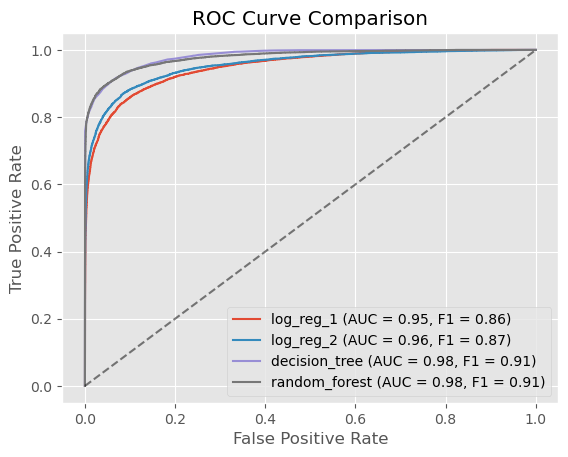

In [64]:
def train_and_plot(clfs_hyperpara, X_train, y_train, X_val, y_val):
    for name, params in clfs_hyperpara.items():
        print(f"Classifier: {color.RED}{color.BOLD}{name}{color.END}")
        if 'log_reg_1' in name:
            if params['penalty'] == 'l1':
                solver = 'liblinear'
            else:
                solver = 'lbfgs'  
            clf = LogisticRegression(solver=solver, **params)
        elif 'log_reg_2' in name:
            if params['penalty'] == 'l1':
                solver = 'liblinear'
            else:
                solver = 'lbfgs'  
            poly = PolynomialFeatures(2)
            X_train_poly = poly.fit_transform(X_train)
            X_val_poly = poly.transform(X_val)
            clf = LogisticRegression(solver=solver, **params)
            
            # Train the classifier on the entire training dataset
            clf.fit(X_train_poly, y_train)

            # Predict probabilities and class labels for the validation set
            prob_y = clf.predict_proba(X_val_poly)[:, 1]
            pred_y = clf.predict(X_val_poly)

            # Compute ROC curve and AUC score
            fpr, tpr, thresholds = roc_curve(y_val, prob_y)
            roc_auc = auc(fpr, tpr)

            # Compute F1 score
            f1 = f1_score(y_val, pred_y)

            # Print AUC, F1, and hyperparameters
            print(f"AUC: {roc_auc:.2f}, F1: {f1:.2f}, Hyperparameters: {params}")

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f}, F1 = {f1:.2f})")
            continue
        elif 'decision_tree' in name:
            clf = DecisionTreeClassifier(**params)
        elif 'random_forest' in name:
            clf = RandomForestClassifier(**params)
        else:
            continue  # Skip unknown classifier
        
        # Train the classifier on the entire training dataset
        clf.fit(X_train, y_train)

        # Predict probabilities and class labels for the validation set
        prob_y = clf.predict_proba(X_val)[:, 1]
        pred_y = clf.predict(X_val)

        # Compute ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_val, prob_y)
        roc_auc = auc(fpr, tpr)

        # Compute F1 score
        f1 = f1_score(y_val, pred_y)

        # Print AUC, F1, and hyperparameters
        print(f"AUC: {roc_auc:.2f}, F1: {f1:.2f}, Hyperparameters: {params}")

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f}, F1 = {f1:.2f})")

    # Plot random classifier line
    plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5)

    # Add labels and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    
    # Show plot
    plt.show()
    
train_and_plot(clfs_hyperpara, x_train, y_train, x_val, y_val)

For the hyperparameter, both logistic regression have a very low C (Strong penalty), and both tree have max_depth of 10, in order to have the lowest chance of overfitting.

Based on these results, both the decision_tree and random_forest classifiers seem to perform well in terms of AUC and F1 score, and both of them outperform the logistic regression in both AUC and F1. To choose between these 2 tree models, we would like to have a model that is more robust again overfitting and offers higher performance. 

Both model have the same `max_depth = 10`, but generally, a decision tree is more simple and interpretable but prone to overfitting, but a random forest is complex and prevents the risk of overfitting and is widely used in domains such as healthcare. Our data is also imbalance most of the time too, so I decided to choose **Random Forest** as our final model.

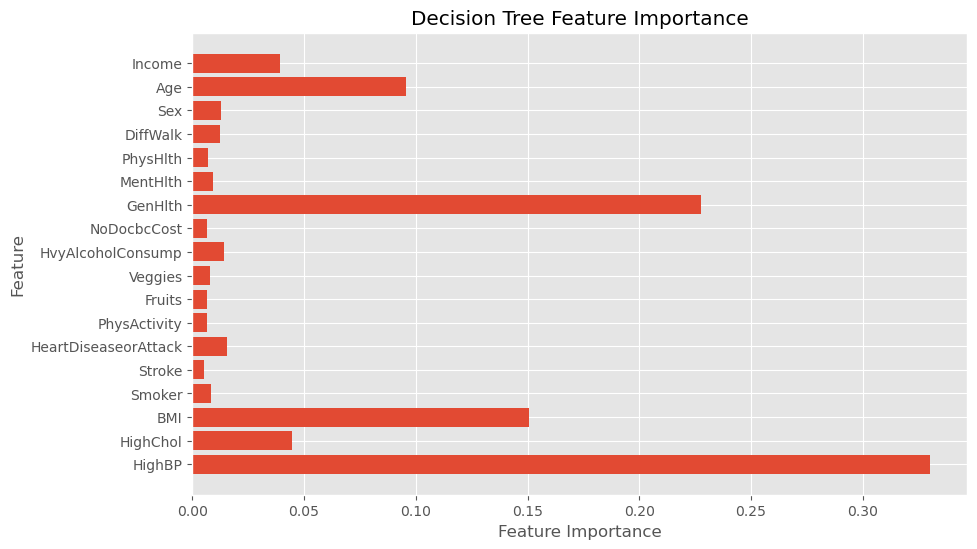

In [79]:
# Train the decision tree model
decision_tree_model = DecisionTreeClassifier(**clfs_hyperpara['decision_tree'])
decision_tree_model.fit(x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]), y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(decision_tree_model.feature_importances_)), decision_tree_model.feature_importances_, align='center')
plt.yticks(range(len(x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]).columns)), x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]).columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importance')
plt.show()

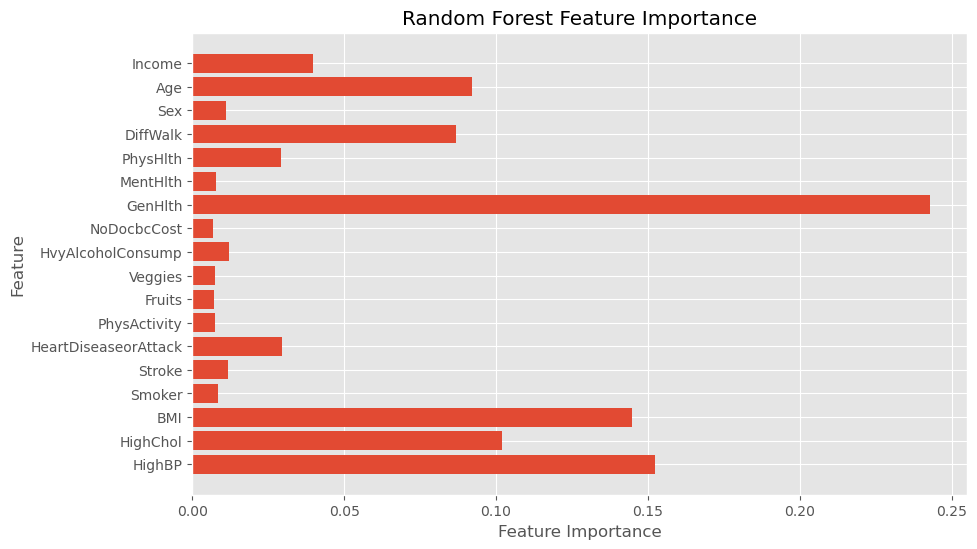

In [76]:
# Train the random forest model
random_forest_model = RandomForestClassifier(**clfs_hyperpara['random_forest'])
random_forest_model.fit(x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]), y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(random_forest_model.feature_importances_)), random_forest_model.feature_importances_, align='center')
plt.yticks(range(len(x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]).columns)), x_train.drop(columns=["ExtraAlcoholTest", "ExtraMedTest"]).columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()